# Model Training

- **Purpose:** Environment setup and loading/validating feature-engineered dataset for fraud model training  
- **Author:** Devbrew LLC  
- **Last Updated:** October 24, 2025  
- **Status:** In progress  
- **License:** Apache 2.0 (Code) | Non-commercial (Data)

---

## Dataset License Notice

This notebook uses the **IEEE-CIS Fraud Detection dataset** from Kaggle.

**Dataset License:** Non-commercial research use only  
- You must download the dataset yourself from [Kaggle IEEE-CIS Competition](https://www.kaggle.com/c/ieee-fraud-detection)  
- You must accept the competition rules before downloading  
- Cannot be used for commercial purposes  
- Cannot redistribute the raw dataset

**Setup Instructions:** See [`../data_catalog/README.md`](../data_catalog/README.md) for download instructions.

**Code License:** This notebook's code is licensed under Apache 2.0 (open source).

---

## Notebook Configuration

### Environment Setup

We configure the Python environment with standardized settings, import required libraries, and set a fixed random seed for reproducibility. This ensures consistent results across runs and enables reliable experimentation.

These settings establish the foundation for all model training operations.

In [2]:
import warnings
from pathlib import Path
import json
import hashlib
from typing import Dict, Any, Optional, Tuple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", '{:.2f}'.format)

# Plotting configuration
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Environment configured successfully")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")

Environment configured successfully
pandas: 2.3.3
numpy: 2.3.3


### Path Configuration

We define the project directory structure and validate that required processed data from feature engineering exists. The validation ensures we have the necessary inputs before proceeding with training.

This configuration pattern ensures we can locate all required data artifacts from previous pipeline stages.

In [3]:
# Project paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data_catalog"
IEEE_CIS_DIR = DATA_DIR / "ieee-fraud"
PROCESSED_DIR = DATA_DIR / "processed"
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"

# Ensure processed directory exists
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Expected artifacts
FEATURES_PATH = PROCESSED_DIR / "train_features.parquet"
FE_METADATA_PATH = PROCESSED_DIR / "feature_engineering_metadata.json"

def validate_required_artifacts():
    """Validate that required artifacts exist before training."""
    path_status = {
        'train_features.parquet': FEATURES_PATH.exists(),
        'feature_engineering_metadata.json': FE_METADATA_PATH.exists()
    }
    print("Artifact Availability Check:")
    for name, exists in path_status.items():
        status = "Found" if exists else "Missing"
        print(f" - {name}: {status}")

    all_exist = all(path_status.values())

    if not all_exist:
        print("\n[WARNING] Some artifacts are missing; ensure feature engineering completed successfully")
    else:
        print("\nAll required artifacts are available")

artifact_status = validate_required_artifacts()

Artifact Availability Check:
 - train_features.parquet: Found
 - feature_engineering_metadata.json: Found

All required artifacts are available


## Load Features & Data Manifest

We load the feature-engineered dataset and validate integrity against recorded metadata. We also create a simple data manifest to document:
- shape
- feature count
- missing values
- target distribution (`isFraud`)
- memory footprint
- file hash (for reproducibility)

### Validation Checklist
- Verify shape matches metadata (590,540 × 432)
- Confirm zero missing values
- Check target distribution (~3.5% fraud rate)
- Validate `TransactionDT` exists for time-based split
- Validate identifiers (`TransactionID`) and target (`isFraud`) are present

In [ ]:
def file_sha256(path: Path, chunk_size: int = 2**20) -> Optional[str]:
    """Compute SHA-256 hash of a file; returns None if file missing"""
    if not path.exists():
        return None
    h = hashlib.sha256()
    with path.open("rb") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

def build_data_manifest(df: pd.DataFrame, file_path: Path, fe_meta: Optional[Dict[str, Any]]) -> Dict[str, Any]:
    """Create a manifest capturing data properties for reproducibility."""
    manifest: Dict[str, Any] = {
        "generated_at": pd.Timestamp.now().isoformat(),
        "source_file": str(file_path),
        "source_hash_sha256": file_sha256(file_path),
        "rows": int(df.shape[0]),
        "columns": int(df.shape[1]),
        "memory_gb": float(df.memory_usage().sum() / 1e9),
        "dtypes_summary": df.dtypes.astype(str).value_counts().to_dict(),
        "null_values_total": int(df.isna().sum().sum()),
        "columns_with_nulls": df.columns[df.isna().any()].tolist(),
        "target": "isFraud",
        "target_distribution": df["isFraud"].value_counts(dropna=False).to_dict() if "isFraud" in df.columns else {},
        "target_rate": float(df["isFraud"].mean()) if "isFraud" in df.columns else None,
        "has_transactiondt": bool("TransactionDT" in df.columns),
        "has_transactionid": bool("TransactionID" in df.columns),
        "random_state": RANDOM_STATE,
    }

    if fe_meta:
        manifest["feature_engineering_metadata"] = {
            "total_features_expected": fe_meta.get("total_features"),
            "dataset_shape_expected": fe_meta.get("dataset_shape"),
            "engineering_date": fe_meta.get("engineering_date"),
        }

    return manifest

# Load feature engineering metadata if available
fe_meta = None
if FE_METADATA_PATH.exists():
    with open(FE_METADATA_PATH, "r") as f:
        fe_meta = json.load(f)

print("Loading Feature-Engineered Data...")
if not FEATURES_PATH.exists():
    raise FileNotFoundError(f"Missing features file: {FEATURES_PATH}")

df = pd.read_parquet(FEATURES_PATH)
print(f"Loaded features: {df.shape[0]:,} rows x {df.shape[1]:,} columns")
print(f"Memory usage: {df.memory_usage().sum() / 1e9:.2f} GB")

# Basic target info
if "isFraud" in df.columns:
    print("\nTarget Distribution:")
    print(pd.Series(df["isFraud"]).value_counts())
    print(f"Fraud rate: {df['isFraud'].mean() * 100:.2f}%")
else:
    print("\n[WARNING] 'isFraud' target column not found in features dataset")

# Data check vs metadata
if fe_meta and "dataset_shape" in fe_meta:
    expected_rows, expected_cols = fe_meta["dataset_shape"]
    ok_shape = (df.shape[0] == expected_rows) and (df.shape[1] == expected_cols)
    print(f"\nShape validation vs metadata: {'PASS' if ok_shape else 'FAIL'}")
    print(f" - (Expected {expected_rows:,} x {expected_cols:,} columns, got {df.shape[0]:,} x {df.shape[1]:,} columns)")
else:
    print("\n[WARNING] Feature engineering metadata not availables for shape validation")

# Nulls
total_nulls = int(df.isnull().sum().sum())
print(f"\nTotal missing values: {total_nulls:,}")

# Key column presence
print(f"Has TransactionDT: {'Yes' if 'TransactionDT' in df.columns else 'No'}")
print(f"Has TransactionID: {'Yes' if 'TransactionID' in df.columns else 'No'}")
    

# Dtypes quick summary
dtype_counts = df.dtypes.astype(str).value_counts()
print("\nDtype Summary:")
for dtype, count in dtype_counts.items():
    print(f" - {dtype}: {count}")

# Build and save manifest
manifest = build_data_manifest(df, FEATURES_PATH, fe_meta)

# Save manifest to data catalog
MANIFEST_PATH = PROCESSED_DIR / "training_data_manifest.json"
MANIFEST_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(MANIFEST_PATH, "w") as f:
    json.dump(manifest, f, indent=4)
print(f"\nTraining data manifest saved to: {MANIFEST_PATH}")

Loading Feature-Engineered Data...
Loaded features: 590,540 rows x 432 columns
Memory usage: 2.04 GB

Target Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud rate: 3.50%

Shape validation vs metadata: PASS
 - (Expected 590,540 x 432 columns, got 590,540 x 432 columns)

Total missing values: 0
Has TransactionDT: Yes
Has TransactionID: Yes

Dtype Summary:
 - float64: 394
 - object: 29
 - int64: 9

Training data manifest saved to: /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/training_data_manifest.json


### Notes

- Shapes validated against [feature_engineering_metadata.json](../data_catalog/processed/feature_engineering_metadata.json): expected `(590,540 × 432)`.  
- `TransactionDT` presence is required for time-based splits in train/test/validation split.  
- We persist a `training_data_manifest.json` documenting data properties and file hash for reproducibility.  

## Train/Validation/Test Split (Time-Based)

We perform a chronological split to respect temporal causality in fraud detection. Random splitting would allow the model to see future data during training, inflating performance metrics and violating real-world deployment conditions.

We split the data into 60% train (earliest transactions), 20% validation (middle period), and 20% test (most recent transactions). This simulates production deployment where models score transactions as they arrive over time, and ensures fraudsters' evolving tactics are properly reflected in our evaluation.

This approach follows industry standards for fraud detection in payment systems and meets regulatory requirements for model validation.

In [ ]:
SPLITS_DIR = PROCESSED_DIR / "splits"
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

def temporal_split(
    df_in: pd.DataFrame, 
    ts_col: str = "TransactionDT",
    id_col: str = "TransactionID",
    target_col: str = "isFraud",
    train_frac: float = 0.60,
    val_frac: float = 0.20,
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict[str, Any]]:
    """
    Perform chronological time-based split with temporal leak prevention for fraud detection.
    
    Ensures training data is strictly earlier than validation/test data. This is critical for
    fraud models where future patterns must not leak into training. Common issue in
    production: models trained with random splits show inflated metrics but fail in
    real-time scoring due to temporal leakage.
    
    Parameters:
        df_in: Input dataframe with transactions
        ts_col: Timestamp column for temporal ordering (default: "TransactionDT")
        id_col: Transaction ID column (default: "TransactionID")
        target_col: Binary fraud label (default: "isFraud")
        train_frac: Training fraction (default: 0.60)
        val_frac: Validation fraction (default: 0.20, test gets remainder)
    
    Returns:
        train_df, val_df, test_df: Chronologically split dataframes
        splits_df: Metadata with split labels for visualization
        stats: Comprehensive dict with:
            - Split metrics and temporal boundaries
            - Class distribution and drift analysis (fraud rate shifts)
            - Validation checks (no temporal leakage, no ID overlap)
            - Dataset provenance for reproducibility
    
    Validations performed:
        - Strict temporal ordering: train_max < val_min < test_max
        - No transaction ID overlap between splits
        - Fraud rate drift monitoring (flags if >0.5pp shift between splits)
    """
    # Sort chronologically to ensure temporal ordering for time-series split
    df_sorted = df_in.sort_values(ts_col).reset_index(drop=True)

    # Compute split indices based on configured fractions
    n = len(df_sorted)
    train_end = int(n * train_frac)
    val_end = int(n * (train_frac + val_frac))

    train_df = df_sorted.iloc[:train_end]
    val_df = df_sorted.iloc[train_end:val_end]
    test_df = df_sorted.iloc[val_end:]

    # Create split labels dataframe for visualization and distribution analysis
    split_labels = (['train'] * len(train_df)) + \
                  (['val'] * len(val_df)) + \
                  (['test'] * len(test_df))
    splits_df = df_sorted[[id_col, ts_col, target_col]].copy()
    splits_df['split'] = split_labels

    # Validate temporal boundaries: critical check for preventing data leakage
    train_max_ts = float(train_df[ts_col].max())
    val_min_ts = float(val_df[ts_col].min())
    val_max_ts = float(val_df[ts_col].max())
    test_min_ts = float(test_df[ts_col].min())

    no_temporal_leak_train_val = train_max_ts < val_min_ts
    no_temporal_leak_val_test = val_max_ts < test_min_ts 

    # Verify no transaction ID overlap across splits
    train_ids = set(train_df[id_col].tolist())
    val_ids = set(val_df[id_col].tolist())
    test_ids = set(test_df[id_col].tolist())
    
    no_id_overlap = (len(train_ids & val_ids) == 0) and \
                    (len(train_ids & test_ids) == 0) and \
                    (len(val_ids & test_ids) == 0)

    # Compute fraud rate drift across splits to monitor distribution stability
    def rate(d: pd.DataFrame) -> float:
        """Calculate fraud rate (mean of binary target)"""
        return float(d[target_col].mean() if len(d) else float('nan'))
    
    train_rate = rate(train_df)
    val_rate = rate(val_df)
    test_rate = rate(test_df)

    drift_train_val_pp = abs(train_rate - val_rate) * 100
    drift_train_test_pp = abs(train_rate - test_rate) * 100
    drift_val_test_pp = abs(val_rate - test_rate) * 100
    
    # Assemble comprehensive statistics and validation results
    try:
        source_hash = manifest.get("source_hash_sha256") if isinstance(manifest, dict) else None
    except NameError:
        source_hash = None
    
    stats: Dict[str, Any] = {
        "method": "time_chronological_split",
        "fractions": {
            "train": train_frac,
            "val": val_frac,
            "test": 1.0 - train_frac - val_frac
        },
        "counts": {
            "train": int(len(train_df)),
            "val": int(len(val_df)),
            "test": int(len(test_df)),
            "total": int((n))
        },
        "timestamp_cutoffs": {
            "train_max": train_max_ts,
            "val_min": val_min_ts,
            "val_max": val_max_ts,
            "test_min": test_min_ts
        },
        "class_rates": {
            "train_rate": train_rate,
            "val_rate": val_rate,
            "test_rate": test_rate
        },
        "drift_pp": {
            "train_vs_val": drift_train_val_pp,
            "train_vs_test": drift_train_test_pp,
            "val_vs_test": drift_val_test_pp
        },
        "checks": {
            "no_temporal_leak_train_val": bool(no_temporal_leak_train_val),
            "no_temporal_leak_val_test": bool(no_temporal_leak_val_test),
            "no_overlap_by_id": bool(no_id_overlap),
            "fraud_rate_similarity_within_0_5_pp": bool((drift_train_val_pp <= 0.5) and (drift_val_test_pp <= 0.5))
        },
        "dataset_provenance": {
            "features_path": str(FEATURES_PATH),
            "source_hash_sha256": source_hash or file_sha256(FEATURES_PATH),
            "random_state": RANDOM_STATE
        }
    }

    return train_df, val_df, test_df, splits_df, stats

### Execute Split and Persist Artifacts

We execute the temporal split, save the split indices for reproducibility, and validate data quality checks.

**Key Industry Context:**
- Random splits can inflate model performance by 10-20 percentage points
- Regulatory frameworks (SR 11-7, Model Risk Management) require temporal validation
- Production fraud models must handle concept drift as fraudsters adapt tactics

In [ ]:
# Execute the temporal split
train_df, val_df, test_df, splits_index_df, split_stats = temporal_split(df)

# Persists split indices and metadata
splits_index_path = SPLITS_DIR / "temporal_splits.csv"
splits_index_df[['TransactionID', 'split']].to_csv(splits_index_path, index=False)

for name, part in [('train', train_df), ('val', val_df), ('test', test_df)]:
    out_path = SPLITS_DIR / f"{name}_ids.csv"
    out_path.write_text("TransactionID\n" + "\n" .join(part["TransactionID"].astype(str).tolist()))

with open(SPLITS_DIR / "splits_metadata.json", "w") as f:
    json.dump(split_stats, f, indent=4)

# Summary
print("Time-based split complete. Summary:")
print(f" - Counts: train={split_stats['counts']['train']:,}, val={split_stats['counts']['val']:,}, test={split_stats['counts']['test']:,}")
print(" - Timestamp cutoffs:")
print(f"   - train_max < val_min < test_min => {split_stats['checks']['no_temporal_leak_train_val']} & {split_stats['checks']['no_temporal_leak_val_test']}")
print(f" - Fraud rates (%):")
print(f"   - train={split_stats['class_rates']['train_rate']*100:.2f}, val={split_stats['class_rates']['val_rate']*100:.2f}, test={split_stats['class_rates']['test_rate']*100:.2f}")
print(f" - Drift (pp):")
print(f"   - train-vs-val={split_stats['drift_pp']['train_vs_val']:.3f}, train-vs-test={split_stats['drift_pp']['train_vs_test']:.3f}, val-vs-test={split_stats['drift_pp']['val_vs_test']:.3f}")
print(f" - No overlap by ID: {split_stats['checks']['no_overlap_by_id']}")
print(f" - Fraud rate similarity within ±0.5pp (train/val and val/test): {split_stats['checks']['fraud_rate_similarity_within_0_5_pp']}")
print(f"Artifacts saved to: {SPLITS_DIR}")

Time-based split complete. Summary:
 - Counts: train=354,324, val=118,108, test=118,108
 - Timestamp cutoffs:
   - train_max < val_min < test_min => True & True
 - Fraud rates (%):
   - train=3.38, val=3.90, test=3.44
 - Drift (pp):
   - train-vs-val=0.521, train-vs-test=0.058, val-vs-test=0.463
 - No overlap by ID: True
 - Fraud rate similarity within ±0.5pp (train/val and val/test): False
Artifacts saved to: /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/splits


### Data Quality Validation

We assert critical data quality checks that would fail a production model review:
- **Temporal leakage prevention**: Ensures no future data contaminates training
- **ID uniqueness**: Prevents same transaction appearing in multiple splits  
- **Distribution monitoring**: Flags significant fraud rate shifts requiring investigation

These checks align with model governance requirements at financial institutions.

In [17]:
assert split_stats["checks"]["no_temporal_leak_train_val"], "Temporal leak between train and val!"
assert split_stats["checks"]["no_temporal_leak_val_test"], "Temporal leak between val and test!"
assert split_stats["checks"]["no_overlap_by_id"], "Transaction ID overlap across splits!"
if not split_stats["checks"]["fraud_rate_similarity_within_0_5_pp"]:
    print(f"[WARNING] Fraud rate drift between exceeds ±0.5pp. Investigate distribution shift or adjust boundaries")

[WARNING] Fraud rate drift between exceeds ±0.5pp. Investigate distribution shift or adjust boundaries


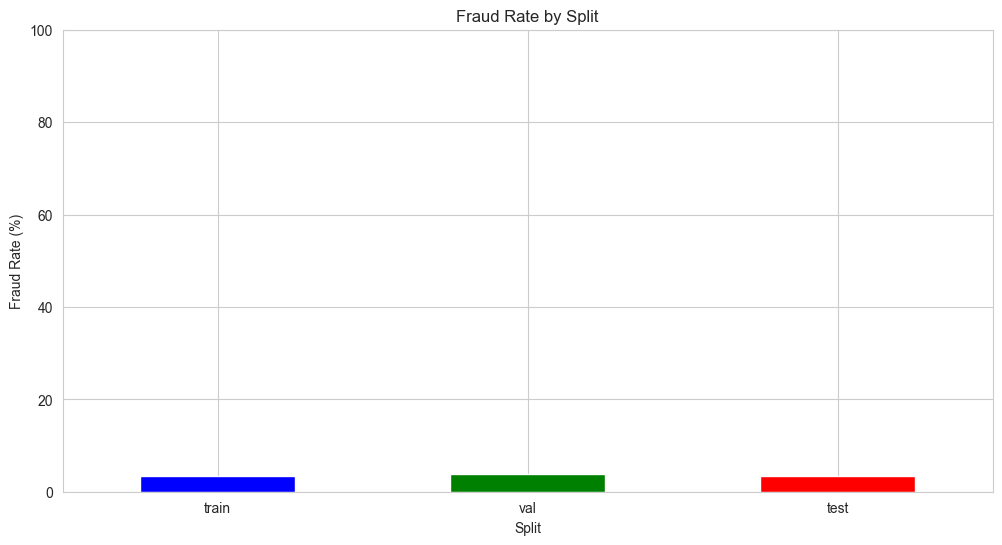

In [18]:
# Visual check of fraud rate by split
split_rates = pd.Series({
    "train": split_stats["class_rates"]["train_rate"] * 100,
    "val": split_stats["class_rates"]["val_rate"] * 100,
    "test": split_stats["class_rates"]["test_rate"] * 100
})

ax = split_rates.plot(kind="bar", rot=0, color=["blue", "green", "red"])
ax.set_title("Fraud Rate by Split")
ax.set_xlabel("Split")
ax.set_ylabel("Fraud Rate (%)")
ax.set_ylim(0, 100)
plt.show()


### Notes

- Fraud rate drift between train/validation is **0.521pp** (0.021pp above threshold), indicating modest distribution shift typical of evolving fraud patterns over time
- This reflects realistic temporal evolution in fraud patterns common in production systems
- Validation/test drift is **0.463pp** (within threshold)
- All critical temporal leakage checks passed; splits maintain strict chronological ordering
- Model performance monitoring in production should track similar drift metrics